# EC500 - Group 6 - UNet-based Standard Deviation Noise Maps of CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [1]:
!pip install pynrrd
!pip install SimpleITK
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install monai --upgrade

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install patchify

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [40]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms import v2
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy import ndimage
import tempfile
import shutil
import glob

In [41]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    Activations,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureChannelFirst,
    Compose,
    AsChannelLastd,
    CropForegroundd,
    ScaleIntensityd,
    LoadImaged,
    Orientationd,
    Spacingd,
    Invertd,
    RandSpatialCropSamplesd,
    RandSpatialCropSamples,
    RandSpatialCropd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    RandRotated,
    RandFlipd,
    RandZoomd,
    RandScaleIntensityd, 
    RandShiftIntensityd,
    #AddChannel,
    ToTensord,
    NormalizeIntensityd
)
from monai.handlers.utils import from_engine 
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference 
from monai.inferers import SlidingWindowInferer
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch, pad_list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from patchify import patchify
import monai.transforms as mTransforms
import math
import torch.nn.functional as F


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [42]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [43]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Section-2: Initial data inspection and experimentation

In [5]:
# initializing directory
data_dir1 = "/projectnb/ec500kb/projects/Project6/scans"
data_dir2 = "/projectnb/ec500kb/projects/Project6/aug_scans"

In [6]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []

for filename in os.listdir(data_dir):
    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
size_check = all(size == sizes[0] for size in sizes)
shape_check = all(shape == shapes[0] for shape in shapes)

if dims_check and size_check and shape_check:
    print('Dimensions, shapes and sizes are uniform')
else:
    print('Dimensions, shapes and sizes are NOT uniform')
    
print('The total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes are NOT uniform
The total number of images in the dataset is 30


In [7]:
list(shapes)

[(512, 512, 318),
 (512, 512, 318),
 (512, 512, 823),
 (512, 512, 526),
 (512, 512, 610),
 (512, 512, 823),
 (512, 512, 600),
 (512, 512, 525),
 (512, 512, 560),
 (512, 512, 856),
 (512, 512, 560),
 (512, 512, 610),
 (512, 512, 600),
 (512, 512, 610),
 (512, 512, 585),
 (512, 512, 318),
 (512, 512, 525),
 (512, 512, 526),
 (512, 512, 526),
 (512, 512, 823),
 (512, 512, 525),
 (512, 512, 600),
 (512, 512, 856),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 533),
 (512, 512, 560),
 (512, 512, 533),
 (512, 512, 585),
 (512, 512, 856)]

In [8]:
def convert_to_2d(img_volume, axis=1):
    return np.max(img_volume, axis=axis)

trans = transforms.Compose([
    transforms.ToTensor()
    #transforms.Resize((512,512)),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

In [9]:
volume, header = nrrd.read(os.path.join(data_dir,'L506_signal.nrrd'))
volume_2d = convert_to_2d(volume)
volume_2d = trans(volume_2d)
print(volume.shape, volume_2d.squeeze().shape, volume_2d.dtype)

(512, 512, 526) torch.Size([512, 526]) torch.int16


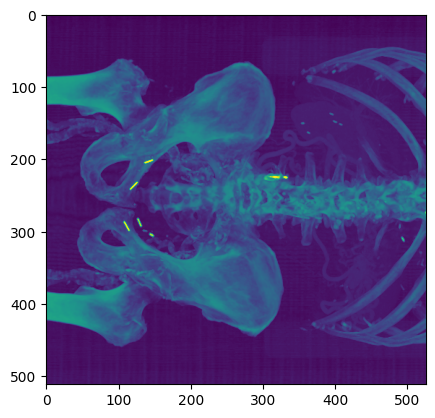

In [10]:
plt.imshow(volume_2d.squeeze())
plt.show()

In [11]:
#volume_2d = volume_2d.numpy()
#volume_2d.dtype

In [11]:
def patches(image):
    demo_dict = []
    image = image.squeeze()
    patches = patchify(image.numpy(), (64,64), step=64)
        
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            single_patch_img = patches[i,j,:,:]
            demo_dict.append(single_patch_img)
    return demo_dict

In [12]:
patch1 = patches(volume_2d)

In [13]:
len(patch1)

64

In [15]:
patch1[2].shape

(64, 64)

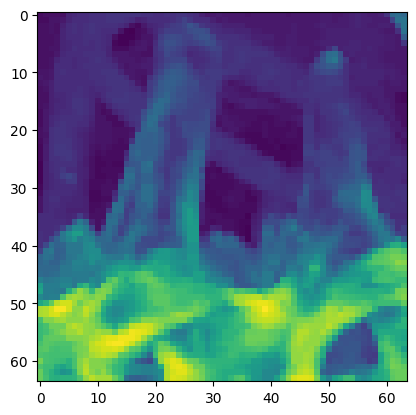

In [16]:
plt.imshow(patch1[30])

## Set deterministic seed for reproducibility

In [14]:
# 4, 54, 104
set_determinism(seed=4)

## Section-3: Creating a custom dataset and making transforms for augmentation


In [15]:
class CustomData(torch.utils.data.Dataset):

    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.data = []
        #self.transforms = transforms
        image_sizes = []
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0]
                
                # reading in the images
                signal_nrrd, _ = nrrd.read(os.path.join(self.root_dir, file))
                noise_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_noise.nrrd"))
                std_nrrd, _ = nrrd.read(os.path.join(self.root_dir, f"{image_id}_std.nrrd"))
                
                # Convert to 2D Axial and to tensors
                signal = torch.tensor(np.max(signal_nrrd, axis=1), dtype=torch.float32)
                noise = torch.tensor(np.max(noise_nrrd, axis=1), dtype=torch.float32)
                std = torch.tensor(np.max(std_nrrd, axis=1), dtype=torch.float32)

                # Normalize the images
                #signal = (signal - signal.min()) / (signal.max() - signal.min())
                #noise = (noise - noise.min()) / (noise.max() - noise.min())
                #std = (std - std.min()) / (std.max() - std.min())

                # generating input image fromm signal and noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)
                
                # generating patches
                ct_patches = patches(ct_generated)
                std_patches = patches(std)
                #print(ct_generated.shape, len(ct_patches), len(std_patches))
                
                # storing the new dataset in a dictionary
                for i in range(len(ct_patches)):
                    self.data.append({'ct_generated' : ct_patches[i], 'std_map' : std_patches[i]})
                
                
    def data_info(self, idx):
        item = self.data[idx]
        ct_gen = item['ct_generated']
        std_ma = item['std_map']

        # Print the index of the data item
        print(f"Data item {idx}:")

        # Print the shape of the ct_generated tensor
        print(f"ct_generated shape: {ct_gen.shape}")

        # Print the shape of the std_map tensor
        print(f"std_map shape: {std_ma.shape}")
        
        print(f"ct_generated dtype: {ct_gen.dtype}")
        print(f"std_map dtype: {ct_gen.dtype}")

        print()
            
            
    def plot_ct(self, idx):
        item = self.data[idx]
        ct_generated = item['ct_generated']
        std_map = item['std_map']
        
        # Create a figure
        plt.figure(figsize=(5,5))
        
        # Plot axial view of ct_generated
        plt.subplot(1, 2, 1)
        plt.imshow(ct_generated, cmap='gray')
        plt.title('ct_generated Patch-0')
        plt.axis('off')
        
        # Plot axial view of std_map
        plt.subplot(1, 2, 2)
        plt.imshow(std_map, cmap='hot')
        plt.title('std_map Patch-0')
        plt.axis('off')
        
        # Show the plots
        plt.show()

            
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        #item = self.transforms(item)
        return item

In [16]:
custom_dataset = CustomData(root_dir = data_dir)

In [39]:
len(custom_dataset)

704

In [40]:
custom_dataset.data_info(10)

Data item 10:
ct_generated shape: (64, 64)
std_map shape: (64, 64)
ct_generated dtype: float32
std_map dtype: float32



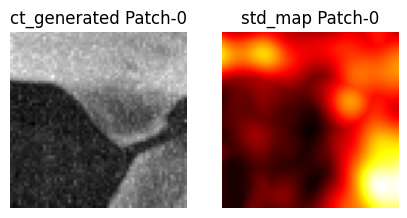

In [41]:
custom_dataset.plot_ct(12)

In [17]:
# transforms for data augmentation and refining

train_transforms = transforms.Compose([#ScaleIntensityd(keys = ['ct_generated', 'std_map']), 
                                       RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True) 
                                       #RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5), 
                                       #RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5) 
])

val_transforms = transforms.Compose([#ScaleIntensityd(keys = ['ct_generated', 'std_map']),
                                     RandRotated(keys = ['ct_generated', 'std_map'], range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True)
                                     #RandFlipd(keys = ['ct_generated', 'std_map'], spatial_axis = 0, prob = 0.5, keep_size = True)
                                     #RandZoomd(keys = ['ct_generated', 'std_map'], zoom = (0.9,1.1), prob = 0.5, keep_size = True) 
])

## Section-4: Data Loader

In [18]:
train_dataset, val_dataset, test_dataset = custom_dataset[:568], custom_dataset[568:640], custom_dataset[640:]
#train_dataset, val_dataset, test_dataset = custom_dataset[:512], custom_dataset[512:576], custom_dataset[576:]
batch_size=1

#train_dataset, testval = train_test_split(custom_dataset, test_size=0.2, random_state=42, shuffle=False)
#val_dataset, test_dataset = train_test_split(testval, test_size=0.5, random_state=42, shuffle=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
print(len(train_loader), len(val_loader), len(test_loader))

568 72 64


In [19]:
# Function to print the size of DataLoader
def print_dataloader_sizes(loader, name):
    # Total number of samples
    total_samples = len(loader.dataset)
    
    # Number of batches
    num_batches = len(loader)
    
    # Assuming all batches have the same size except possibly the last one
    batch_size = loader.batch_size
    
    print(f'{name} DataLoader has:')
    print(f'  Total samples: {total_samples}')
    print(f'  Number of batches: {num_batches}')
    print(f'  Batch size: {batch_size}')
    if total_samples % batch_size != 0:
        print(f'  Last batch size: {total_samples % batch_size}')
    else:
        print(f'  All batches have the same size')

# Checking sizes for each DataLoader
print_dataloader_sizes(train_loader, 'Train')
print_dataloader_sizes(val_loader, 'Validation')
print_dataloader_sizes(test_loader, 'Test')


Train DataLoader has:
  Total samples: 568
  Number of batches: 568
  Batch size: 1
  All batches have the same size
Validation DataLoader has:
  Total samples: 72
  Number of batches: 72
  Batch size: 1
  All batches have the same size
Test DataLoader has:
  Total samples: 64
  Number of batches: 64
  Batch size: 1
  All batches have the same size


## Section-6: RATUNet Training and Testing

In [20]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.0):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),  # Dropout layer added here
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)  # Dropout layer added here
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class RatUNet(nn.Module):
    def __init__(self, block, num_features=64, dropout_rate=0.0): 
        super(RatUNet, self).__init__()
        self.inplanes = num_features

        #self.conv = DoubleConv(1, num_features, dropout_rate=dropout_rate) 
        self.conv = nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1, bias=True)

        self.layer1 = self._make_layer(block, 64, 128, 3, stride=2)
        self.layer2 = self._make_layer(block, 128, 256, 3, stride=2)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, 512, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

        self.layer4 = self._make_layer(block, 256, 256, 3)
        self.layer5 = self._make_layer(block, 128, 128, 3)
        self.layer6 = self._make_layer(block, 128, 128, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=True),
                                   nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
                                   nn.ReLU(inplace=True),
                                   )
        self.ca = SequentialPolarizedSelfAttention(128)
        self.lastconv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0.0, math.sqrt(1.0 / n))
                if m.bias is not None:  # Check if the bias is not None before zeroing it
                    m.bias.data.zero_()

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        downsample = None
        self.inplanes = inplanes
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(planes),
                nn.AvgPool2d(kernel_size=2, stride=stride)
            )
            
#        if  stride == 1 and self.inplanes == 2*planes:
#            downsample = nn.Sequential(
#                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
#                #nn.BatchNorm2d(planes)
#            )
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        res = self.conv(x)

        res2 = self.layer1(res)
        res3 = self.layer2(res2)        
        out = self.layer3(res3)
        
        out = self.deconv1(out)               
        out = self.layer4(out)
        out = torch.cat((out, res3), dim=1) 

        out = self.deconv2(out)        
        out = self.layer5(out)
        out = torch.cat((out, res2), dim=1)
        
        out = self.deconv3(out)        
        out = self.layer6(out)
        out = torch.cat((out, res), dim=1)
        
        out = self.conv2(out)
        out = self.ca(out)
        #out = self.lastconv(out)
        noise_pred = self.lastconv(out)
        
        #return x - out
        return noise_pred


In [21]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1, downsample=None, dropout_rate=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer added here
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)  # Dropout applied here

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.dropout(out)  # Dropout applied here

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


In [22]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=True),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SequentialPolarizedSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.ch_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.ch_wq=nn.Conv2d(channel,1,kernel_size=(1,1))
        self.softmax_channel=nn.Softmax(1)
        self.softmax_spatial=nn.Softmax(-1)
        self.ch_wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))
        self.ln=nn.LayerNorm(channel)
        self.sigmoid=nn.Sigmoid()
        self.sp_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.sp_wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.agp=nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        b, c, h, w = x.size()

        #Channel-only Self-Attention
        channel_wv=self.ch_wv(x) #bs,c//2,h,w
        channel_wq=self.ch_wq(x) #bs,1,h,w
        channel_wv=channel_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        channel_wq=channel_wq.reshape(b,-1,1) #bs,h*w,1
        channel_wq=self.softmax_channel(channel_wq)
        channel_wz=torch.matmul(channel_wv,channel_wq).unsqueeze(-1) #bs,c//2,1,1
        channel_weight=self.sigmoid(self.ch_wz(channel_wz).reshape(b,c,1).permute(0,2,1)).permute(0,2,1).reshape(b,c,1,1) #bs,c,1,1self.ln(
        channel_out=channel_weight*x

        #Spatial-only Self-Attention
        spatial_wv=self.sp_wv(channel_out) #bs,c//2,h,w
        spatial_wq=self.sp_wq(channel_out) #bs,c//2,h,w
        spatial_wq=self.agp(spatial_wq) #bs,c//2,1,1
        spatial_wv=spatial_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        spatial_wq=spatial_wq.permute(0,2,3,1).reshape(b,1,c//2) #bs,1,c//2
        spatial_wq=self.softmax_spatial(spatial_wq)
        spatial_wz=torch.matmul(spatial_wq,spatial_wv) #bs,1,h*w
        spatial_weight=self.sigmoid(spatial_wz.reshape(b,1,h,w)) #bs,1,h,w
        spatial_out=spatial_weight*channel_out
        return spatial_out


In [23]:
# LOSS Function - Average Relative Error
def average_relative_error(output, target):
    absolute_error = torch.abs(output - target)
    nonzero_mask = target != 0  # Mask for non-zero elements in target
    return torch.mean(torch.abs((absolute_error[nonzero_mask] / target[nonzero_mask])))

In [27]:
# Model and optimizer initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
#model = RatUNet(BasicBlock, 64).to(device)
model = RatUNet(BasicBlock, num_features=64, dropout_rate=0.0).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model_saving_path = './results/RatUNet_seed104_nodr.pth'

# Train the model
total_step = len(train_loader)
num_epochs = 200
best_val_loss = float('inf')  # Initialize best validation loss for model saving

In [79]:
# training and validation

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        img = img.unsqueeze(0)
        std_map = images['std_map'].float().to(device)
        std_map = std_map.unsqueeze(0)
        #print(img.shape)
        #print(std_map.shape)
        optimizer.zero_grad()
        y_pred = model(img)
        #print(y_pred.shape)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            img = img.unsqueeze(0)
            std_map = image['std_map'].float().to(device)
            std_map = std_map.unsqueeze(0)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Save model if validation loss has improved
        if epoch_val_loss < best_val_loss:
            print(f"Validation loss decreased ({best_val_loss:.6f} --> {epoch_val_loss:.6f}).  Saving model ...")
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), model_saving_path)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


100%|██████████| 72/72 [00:00<00:00, 394.72it/s]


Validation loss decreased (inf --> 0.491399).  Saving model ...
Epoch [1/200], Train Loss: 0.5810, Validation Loss: 0.4914


100%|██████████| 72/72 [00:00<00:00, 397.74it/s]


Validation loss decreased (0.491399 --> 0.451669).  Saving model ...
Epoch [2/200], Train Loss: 0.3012, Validation Loss: 0.4517


100%|██████████| 72/72 [00:00<00:00, 394.68it/s]


Epoch [3/200], Train Loss: 0.2380, Validation Loss: 0.4705


100%|██████████| 72/72 [00:00<00:00, 396.69it/s]


Validation loss decreased (0.451669 --> 0.423626).  Saving model ...
Epoch [4/200], Train Loss: 0.2173, Validation Loss: 0.4236


100%|██████████| 72/72 [00:00<00:00, 397.04it/s]


Epoch [5/200], Train Loss: 0.2092, Validation Loss: 0.4267


100%|██████████| 72/72 [00:00<00:00, 397.75it/s]


Validation loss decreased (0.423626 --> 0.398033).  Saving model ...
Epoch [6/200], Train Loss: 0.1925, Validation Loss: 0.3980


100%|██████████| 72/72 [00:00<00:00, 395.50it/s]


Epoch [7/200], Train Loss: 0.1757, Validation Loss: 0.4503


100%|██████████| 72/72 [00:00<00:00, 395.90it/s]


Validation loss decreased (0.398033 --> 0.392455).  Saving model ...
Epoch [8/200], Train Loss: 0.1543, Validation Loss: 0.3925


100%|██████████| 72/72 [00:00<00:00, 398.06it/s]


Epoch [9/200], Train Loss: 0.1390, Validation Loss: 0.4719


100%|██████████| 72/72 [00:00<00:00, 395.38it/s]


Validation loss decreased (0.392455 --> 0.379500).  Saving model ...
Epoch [10/200], Train Loss: 0.1314, Validation Loss: 0.3795


100%|██████████| 72/72 [00:00<00:00, 398.27it/s]


Validation loss decreased (0.379500 --> 0.373957).  Saving model ...
Epoch [11/200], Train Loss: 0.1192, Validation Loss: 0.3740


100%|██████████| 72/72 [00:00<00:00, 399.75it/s]


Epoch [12/200], Train Loss: 0.1136, Validation Loss: 0.3750


100%|██████████| 72/72 [00:00<00:00, 397.92it/s]


Epoch [13/200], Train Loss: 0.1052, Validation Loss: 0.4136


100%|██████████| 72/72 [00:00<00:00, 400.55it/s]


Epoch [14/200], Train Loss: 0.1023, Validation Loss: 0.3782


100%|██████████| 72/72 [00:00<00:00, 399.56it/s]


Validation loss decreased (0.373957 --> 0.369611).  Saving model ...
Epoch [15/200], Train Loss: 0.1139, Validation Loss: 0.3696


100%|██████████| 72/72 [00:00<00:00, 400.44it/s]


Epoch [16/200], Train Loss: 0.0990, Validation Loss: 0.3739


100%|██████████| 72/72 [00:00<00:00, 398.21it/s]


Epoch [17/200], Train Loss: 0.0858, Validation Loss: 0.3708


100%|██████████| 72/72 [00:00<00:00, 399.42it/s]


Epoch [18/200], Train Loss: 0.0817, Validation Loss: 0.3916


100%|██████████| 72/72 [00:00<00:00, 399.44it/s]


Epoch [19/200], Train Loss: 0.0814, Validation Loss: 0.4365


100%|██████████| 72/72 [00:00<00:00, 401.31it/s]


Epoch [20/200], Train Loss: 0.0793, Validation Loss: 0.3726


100%|██████████| 72/72 [00:00<00:00, 401.51it/s]


Epoch [21/200], Train Loss: 0.0755, Validation Loss: 0.3946


100%|██████████| 72/72 [00:00<00:00, 401.39it/s]


Validation loss decreased (0.369611 --> 0.340364).  Saving model ...
Epoch [22/200], Train Loss: 0.0718, Validation Loss: 0.3404


100%|██████████| 72/72 [00:00<00:00, 400.80it/s]


Epoch [23/200], Train Loss: 0.0678, Validation Loss: 0.3549


100%|██████████| 72/72 [00:00<00:00, 401.50it/s]


Epoch [24/200], Train Loss: 0.0647, Validation Loss: 0.3500


100%|██████████| 72/72 [00:00<00:00, 400.95it/s]


Epoch [25/200], Train Loss: 0.0616, Validation Loss: 0.4028


100%|██████████| 72/72 [00:00<00:00, 400.61it/s]


Epoch [26/200], Train Loss: 0.0598, Validation Loss: 0.3653


100%|██████████| 72/72 [00:00<00:00, 399.26it/s]


Epoch [27/200], Train Loss: 0.0578, Validation Loss: 0.3915


100%|██████████| 72/72 [00:00<00:00, 390.10it/s]


Epoch [28/200], Train Loss: 0.0553, Validation Loss: 0.4445


100%|██████████| 72/72 [00:00<00:00, 396.95it/s]


Epoch [29/200], Train Loss: 0.0546, Validation Loss: 0.3684


100%|██████████| 72/72 [00:00<00:00, 397.49it/s]


Epoch [30/200], Train Loss: 0.0498, Validation Loss: 0.3839


100%|██████████| 72/72 [00:00<00:00, 397.48it/s]


Epoch [31/200], Train Loss: 0.0490, Validation Loss: 0.3887


100%|██████████| 72/72 [00:00<00:00, 397.54it/s]


Validation loss decreased (0.340364 --> 0.325636).  Saving model ...
Epoch [32/200], Train Loss: 0.0475, Validation Loss: 0.3256


100%|██████████| 72/72 [00:00<00:00, 397.18it/s]


Epoch [33/200], Train Loss: 0.0477, Validation Loss: 0.3916


100%|██████████| 72/72 [00:00<00:00, 393.03it/s]


Epoch [34/200], Train Loss: 0.0459, Validation Loss: 0.3826


100%|██████████| 72/72 [00:00<00:00, 396.97it/s]


Epoch [35/200], Train Loss: 0.0456, Validation Loss: 0.3880


100%|██████████| 72/72 [00:00<00:00, 398.46it/s]


Epoch [36/200], Train Loss: 0.0455, Validation Loss: 0.3549


100%|██████████| 72/72 [00:00<00:00, 398.60it/s]


Epoch [37/200], Train Loss: 0.0432, Validation Loss: 0.3942


100%|██████████| 72/72 [00:00<00:00, 397.08it/s]


Epoch [38/200], Train Loss: 0.0428, Validation Loss: 0.3788


100%|██████████| 72/72 [00:00<00:00, 397.35it/s]


Epoch [39/200], Train Loss: 0.0408, Validation Loss: 0.3895


100%|██████████| 72/72 [00:00<00:00, 397.71it/s]


Epoch [40/200], Train Loss: 0.0415, Validation Loss: 0.4001


100%|██████████| 72/72 [00:00<00:00, 398.62it/s]


Epoch [41/200], Train Loss: 0.0418, Validation Loss: 0.3787


100%|██████████| 72/72 [00:00<00:00, 397.10it/s]


Epoch [42/200], Train Loss: 0.0408, Validation Loss: 0.3799


100%|██████████| 72/72 [00:00<00:00, 397.79it/s]


Epoch [43/200], Train Loss: 0.0398, Validation Loss: 0.4005


100%|██████████| 72/72 [00:00<00:00, 398.07it/s]


Epoch [44/200], Train Loss: 0.0387, Validation Loss: 0.3644


100%|██████████| 72/72 [00:00<00:00, 396.84it/s]


Epoch [45/200], Train Loss: 0.0381, Validation Loss: 0.3447


100%|██████████| 72/72 [00:00<00:00, 397.94it/s]


Epoch [46/200], Train Loss: 0.0372, Validation Loss: 0.3546


100%|██████████| 72/72 [00:00<00:00, 397.34it/s]


Epoch [47/200], Train Loss: 0.0363, Validation Loss: 0.3876


100%|██████████| 72/72 [00:00<00:00, 395.87it/s]


Epoch [48/200], Train Loss: 0.0360, Validation Loss: 0.3881


100%|██████████| 72/72 [00:00<00:00, 397.22it/s]


Epoch [49/200], Train Loss: 0.0355, Validation Loss: 0.4215


100%|██████████| 72/72 [00:00<00:00, 397.71it/s]


Epoch [50/200], Train Loss: 0.0353, Validation Loss: 0.3906


100%|██████████| 72/72 [00:00<00:00, 397.93it/s]


Epoch [51/200], Train Loss: 0.0346, Validation Loss: 0.3554


100%|██████████| 72/72 [00:00<00:00, 398.43it/s]


Epoch [52/200], Train Loss: 0.0350, Validation Loss: 0.3598


100%|██████████| 72/72 [00:00<00:00, 398.07it/s]


Epoch [53/200], Train Loss: 0.0337, Validation Loss: 0.4051


100%|██████████| 72/72 [00:00<00:00, 397.91it/s]


Epoch [54/200], Train Loss: 0.0338, Validation Loss: 0.3928


100%|██████████| 72/72 [00:00<00:00, 397.39it/s]


Epoch [55/200], Train Loss: 0.0342, Validation Loss: 0.3651


100%|██████████| 72/72 [00:00<00:00, 399.24it/s]


Epoch [56/200], Train Loss: 0.0329, Validation Loss: 0.3581


100%|██████████| 72/72 [00:00<00:00, 399.04it/s]


Epoch [57/200], Train Loss: 0.0326, Validation Loss: 0.3855


100%|██████████| 72/72 [00:00<00:00, 397.82it/s]


Epoch [58/200], Train Loss: 0.0312, Validation Loss: 0.3943


100%|██████████| 72/72 [00:00<00:00, 397.47it/s]


Epoch [59/200], Train Loss: 0.0315, Validation Loss: 0.3484


100%|██████████| 72/72 [00:00<00:00, 397.50it/s]


Epoch [60/200], Train Loss: 0.0315, Validation Loss: 0.3462


100%|██████████| 72/72 [00:00<00:00, 398.82it/s]


Epoch [61/200], Train Loss: 0.0308, Validation Loss: 0.4025


100%|██████████| 72/72 [00:00<00:00, 397.36it/s]


Epoch [62/200], Train Loss: 0.0296, Validation Loss: 0.3581


100%|██████████| 72/72 [00:00<00:00, 399.45it/s]


Epoch [63/200], Train Loss: 0.0297, Validation Loss: 0.3888


100%|██████████| 72/72 [00:00<00:00, 400.68it/s]


Epoch [64/200], Train Loss: 0.0292, Validation Loss: 0.3739


100%|██████████| 72/72 [00:00<00:00, 399.70it/s]


Epoch [65/200], Train Loss: 0.0308, Validation Loss: 0.3955


100%|██████████| 72/72 [00:00<00:00, 401.48it/s]


Epoch [66/200], Train Loss: 0.0306, Validation Loss: 0.3713


100%|██████████| 72/72 [00:00<00:00, 400.47it/s]


Epoch [67/200], Train Loss: 0.0286, Validation Loss: 0.3681


100%|██████████| 72/72 [00:00<00:00, 398.87it/s]


Epoch [68/200], Train Loss: 0.0277, Validation Loss: 0.4005


100%|██████████| 72/72 [00:00<00:00, 400.09it/s]


Epoch [69/200], Train Loss: 0.0288, Validation Loss: 0.3918


100%|██████████| 72/72 [00:00<00:00, 400.36it/s]


Epoch [70/200], Train Loss: 0.0283, Validation Loss: 0.4235


100%|██████████| 72/72 [00:00<00:00, 400.85it/s]


Epoch [71/200], Train Loss: 0.0276, Validation Loss: 0.3863


100%|██████████| 72/72 [00:00<00:00, 401.83it/s]


Epoch [72/200], Train Loss: 0.0273, Validation Loss: 0.3640


100%|██████████| 72/72 [00:00<00:00, 399.40it/s]


Epoch [73/200], Train Loss: 0.0289, Validation Loss: 0.3604


100%|██████████| 72/72 [00:00<00:00, 399.33it/s]


Epoch [74/200], Train Loss: 0.0285, Validation Loss: 0.3863


100%|██████████| 72/72 [00:00<00:00, 400.89it/s]


Epoch [75/200], Train Loss: 0.0268, Validation Loss: 0.3722


100%|██████████| 72/72 [00:00<00:00, 398.55it/s]


Epoch [76/200], Train Loss: 0.0267, Validation Loss: 0.3694


100%|██████████| 72/72 [00:00<00:00, 397.91it/s]


Epoch [77/200], Train Loss: 0.0255, Validation Loss: 0.3758


100%|██████████| 72/72 [00:00<00:00, 397.98it/s]


Epoch [78/200], Train Loss: 0.0258, Validation Loss: 0.4229


100%|██████████| 72/72 [00:00<00:00, 397.47it/s]


Epoch [79/200], Train Loss: 0.0257, Validation Loss: 0.3634


100%|██████████| 72/72 [00:00<00:00, 397.99it/s]


Epoch [80/200], Train Loss: 0.0266, Validation Loss: 0.3755


100%|██████████| 72/72 [00:00<00:00, 401.57it/s]


Epoch [81/200], Train Loss: 0.0269, Validation Loss: 0.3596


100%|██████████| 72/72 [00:00<00:00, 399.99it/s]


Epoch [82/200], Train Loss: 0.0258, Validation Loss: 0.3500


100%|██████████| 72/72 [00:00<00:00, 399.42it/s]


Epoch [83/200], Train Loss: 0.0251, Validation Loss: 0.3813


100%|██████████| 72/72 [00:00<00:00, 400.12it/s]


Epoch [84/200], Train Loss: 0.0250, Validation Loss: 0.4537


100%|██████████| 72/72 [00:00<00:00, 400.47it/s]


Epoch [85/200], Train Loss: 0.0250, Validation Loss: 0.3636


100%|██████████| 72/72 [00:00<00:00, 401.77it/s]


Epoch [86/200], Train Loss: 0.0247, Validation Loss: 0.3882


100%|██████████| 72/72 [00:00<00:00, 398.68it/s]


Epoch [87/200], Train Loss: 0.0246, Validation Loss: 0.4033


100%|██████████| 72/72 [00:00<00:00, 400.17it/s]


Epoch [88/200], Train Loss: 0.0235, Validation Loss: 0.3871


100%|██████████| 72/72 [00:00<00:00, 400.81it/s]


Epoch [89/200], Train Loss: 0.0244, Validation Loss: 0.3909


100%|██████████| 72/72 [00:00<00:00, 400.08it/s]


Epoch [90/200], Train Loss: 0.0227, Validation Loss: 0.4021


100%|██████████| 72/72 [00:00<00:00, 401.52it/s]


Epoch [91/200], Train Loss: 0.0233, Validation Loss: 0.4013


100%|██████████| 72/72 [00:00<00:00, 401.16it/s]


Epoch [92/200], Train Loss: 0.0243, Validation Loss: 0.3677


100%|██████████| 72/72 [00:00<00:00, 399.92it/s]


Epoch [93/200], Train Loss: 0.0240, Validation Loss: 0.3847


100%|██████████| 72/72 [00:00<00:00, 400.91it/s]


Epoch [94/200], Train Loss: 0.0233, Validation Loss: 0.3741


100%|██████████| 72/72 [00:00<00:00, 400.39it/s]


Epoch [95/200], Train Loss: 0.0235, Validation Loss: 0.3422


100%|██████████| 72/72 [00:00<00:00, 401.59it/s]


Epoch [96/200], Train Loss: 0.0224, Validation Loss: 0.4050


100%|██████████| 72/72 [00:00<00:00, 401.18it/s]


Epoch [97/200], Train Loss: 0.0223, Validation Loss: 0.3865


100%|██████████| 72/72 [00:00<00:00, 400.30it/s]


Epoch [98/200], Train Loss: 0.0223, Validation Loss: 0.4091


100%|██████████| 72/72 [00:00<00:00, 400.57it/s]


Epoch [99/200], Train Loss: 0.0223, Validation Loss: 0.3558


100%|██████████| 72/72 [00:00<00:00, 399.40it/s]


Epoch [100/200], Train Loss: 0.0213, Validation Loss: 0.3861


100%|██████████| 72/72 [00:00<00:00, 400.87it/s]


Epoch [101/200], Train Loss: 0.0228, Validation Loss: 0.3849


100%|██████████| 72/72 [00:00<00:00, 399.13it/s]


Epoch [102/200], Train Loss: 0.0222, Validation Loss: 0.3905


100%|██████████| 72/72 [00:00<00:00, 401.70it/s]


Epoch [103/200], Train Loss: 0.0345, Validation Loss: 0.4163


100%|██████████| 72/72 [00:00<00:00, 400.58it/s]


Epoch [104/200], Train Loss: 0.0259, Validation Loss: 0.3785


100%|██████████| 72/72 [00:00<00:00, 398.18it/s]


Epoch [105/200], Train Loss: 0.0185, Validation Loss: 0.3968


100%|██████████| 72/72 [00:00<00:00, 398.71it/s]


Epoch [106/200], Train Loss: 0.0169, Validation Loss: 0.4056


100%|██████████| 72/72 [00:00<00:00, 398.09it/s]


Epoch [107/200], Train Loss: 0.0190, Validation Loss: 0.4049


100%|██████████| 72/72 [00:00<00:00, 394.15it/s]


Epoch [108/200], Train Loss: 0.0206, Validation Loss: 0.3514


100%|██████████| 72/72 [00:00<00:00, 397.74it/s]


Epoch [109/200], Train Loss: 0.0206, Validation Loss: 0.3497


100%|██████████| 72/72 [00:00<00:00, 398.35it/s]


Epoch [110/200], Train Loss: 0.0191, Validation Loss: 0.3939


100%|██████████| 72/72 [00:00<00:00, 399.86it/s]


Epoch [111/200], Train Loss: 0.0215, Validation Loss: 0.3824


100%|██████████| 72/72 [00:00<00:00, 398.97it/s]


Epoch [112/200], Train Loss: 0.0211, Validation Loss: 0.4021


100%|██████████| 72/72 [00:00<00:00, 398.56it/s]


Epoch [113/200], Train Loss: 0.0202, Validation Loss: 0.3789


100%|██████████| 72/72 [00:00<00:00, 399.50it/s]


Epoch [114/200], Train Loss: 0.0213, Validation Loss: 0.3828


100%|██████████| 72/72 [00:00<00:00, 399.33it/s]


Epoch [115/200], Train Loss: 0.0210, Validation Loss: 0.3850


100%|██████████| 72/72 [00:00<00:00, 400.40it/s]


Epoch [116/200], Train Loss: 0.0206, Validation Loss: 0.3679


100%|██████████| 72/72 [00:00<00:00, 398.61it/s]


Epoch [117/200], Train Loss: 0.0205, Validation Loss: 0.3771


100%|██████████| 72/72 [00:00<00:00, 398.17it/s]


Epoch [118/200], Train Loss: 0.0191, Validation Loss: 0.4094


100%|██████████| 72/72 [00:00<00:00, 398.51it/s]


Epoch [119/200], Train Loss: 0.0201, Validation Loss: 0.3941


100%|██████████| 72/72 [00:00<00:00, 398.23it/s]


Epoch [120/200], Train Loss: 0.0200, Validation Loss: 0.4291


100%|██████████| 72/72 [00:00<00:00, 399.60it/s]


Epoch [121/200], Train Loss: 0.0209, Validation Loss: 0.3467


100%|██████████| 72/72 [00:00<00:00, 398.95it/s]


Epoch [122/200], Train Loss: 0.0209, Validation Loss: 0.3893


100%|██████████| 72/72 [00:00<00:00, 398.10it/s]


Epoch [123/200], Train Loss: 0.0209, Validation Loss: 0.3901


100%|██████████| 72/72 [00:00<00:00, 401.30it/s]


Epoch [124/200], Train Loss: 0.0209, Validation Loss: 0.3527


100%|██████████| 72/72 [00:00<00:00, 400.86it/s]


Epoch [125/200], Train Loss: 0.0196, Validation Loss: 0.3900


100%|██████████| 72/72 [00:00<00:00, 402.21it/s]


Epoch [126/200], Train Loss: 0.0188, Validation Loss: 0.3763


100%|██████████| 72/72 [00:00<00:00, 400.79it/s]


Epoch [127/200], Train Loss: 0.0184, Validation Loss: 0.3851


100%|██████████| 72/72 [00:00<00:00, 401.71it/s]


Epoch [128/200], Train Loss: 0.0188, Validation Loss: 0.4088


100%|██████████| 72/72 [00:00<00:00, 399.65it/s]


Epoch [129/200], Train Loss: 0.0189, Validation Loss: 0.3990


100%|██████████| 72/72 [00:00<00:00, 398.93it/s]


Epoch [130/200], Train Loss: 0.0186, Validation Loss: 0.4107


100%|██████████| 72/72 [00:00<00:00, 399.46it/s]


Epoch [131/200], Train Loss: 0.0184, Validation Loss: 0.3625


100%|██████████| 72/72 [00:00<00:00, 397.92it/s]


Epoch [132/200], Train Loss: 0.0184, Validation Loss: 0.3900


100%|██████████| 72/72 [00:00<00:00, 397.05it/s]


Epoch [133/200], Train Loss: 0.0193, Validation Loss: 0.4084


100%|██████████| 72/72 [00:00<00:00, 398.29it/s]


Epoch [134/200], Train Loss: 0.0196, Validation Loss: 0.3899


100%|██████████| 72/72 [00:00<00:00, 397.90it/s]


Epoch [135/200], Train Loss: 0.0184, Validation Loss: 0.4026


100%|██████████| 72/72 [00:00<00:00, 399.58it/s]


Epoch [136/200], Train Loss: 0.0178, Validation Loss: 0.4332


100%|██████████| 72/72 [00:00<00:00, 399.02it/s]


Epoch [137/200], Train Loss: 0.0177, Validation Loss: 0.3755


100%|██████████| 72/72 [00:00<00:00, 398.51it/s]


Epoch [138/200], Train Loss: 0.0183, Validation Loss: 0.3914


100%|██████████| 72/72 [00:00<00:00, 397.85it/s]


Epoch [139/200], Train Loss: 0.0185, Validation Loss: 0.4053


100%|██████████| 72/72 [00:00<00:00, 397.53it/s]


Epoch [140/200], Train Loss: 0.0201, Validation Loss: 0.4004


100%|██████████| 72/72 [00:00<00:00, 398.59it/s]


Epoch [141/200], Train Loss: 0.0193, Validation Loss: 0.3716


100%|██████████| 72/72 [00:00<00:00, 398.51it/s]


Epoch [142/200], Train Loss: 0.0230, Validation Loss: 0.3900


100%|██████████| 72/72 [00:00<00:00, 397.77it/s]


Epoch [143/200], Train Loss: 0.0243, Validation Loss: 0.3737


100%|██████████| 72/72 [00:00<00:00, 398.40it/s]


Epoch [144/200], Train Loss: 0.0167, Validation Loss: 0.3859


100%|██████████| 72/72 [00:00<00:00, 397.87it/s]


Epoch [145/200], Train Loss: 0.0166, Validation Loss: 0.3860


100%|██████████| 72/72 [00:00<00:00, 399.90it/s]


Epoch [146/200], Train Loss: 0.0165, Validation Loss: 0.3955


100%|██████████| 72/72 [00:00<00:00, 398.79it/s]


Epoch [147/200], Train Loss: 0.0165, Validation Loss: 0.3871


100%|██████████| 72/72 [00:00<00:00, 398.03it/s]


Epoch [148/200], Train Loss: 0.0157, Validation Loss: 0.3784


100%|██████████| 72/72 [00:00<00:00, 399.15it/s]


Epoch [149/200], Train Loss: 0.0169, Validation Loss: 0.4188


100%|██████████| 72/72 [00:00<00:00, 399.33it/s]


Epoch [150/200], Train Loss: 0.0175, Validation Loss: 0.3745


100%|██████████| 72/72 [00:00<00:00, 400.15it/s]


Epoch [151/200], Train Loss: 0.0176, Validation Loss: 0.3713


100%|██████████| 72/72 [00:00<00:00, 397.65it/s]


Epoch [152/200], Train Loss: 0.0177, Validation Loss: 0.3915


100%|██████████| 72/72 [00:00<00:00, 398.23it/s]


Epoch [153/200], Train Loss: 0.0172, Validation Loss: 0.3706


100%|██████████| 72/72 [00:00<00:00, 401.20it/s]


Epoch [154/200], Train Loss: 0.0174, Validation Loss: 0.4169


100%|██████████| 72/72 [00:00<00:00, 400.98it/s]


Epoch [155/200], Train Loss: 0.0166, Validation Loss: 0.3653


100%|██████████| 72/72 [00:00<00:00, 401.89it/s]


Epoch [156/200], Train Loss: 0.0163, Validation Loss: 0.4113


100%|██████████| 72/72 [00:00<00:00, 401.06it/s]


Epoch [157/200], Train Loss: 0.0177, Validation Loss: 0.3753


100%|██████████| 72/72 [00:00<00:00, 401.20it/s]


Epoch [158/200], Train Loss: 0.0170, Validation Loss: 0.3839


100%|██████████| 72/72 [00:00<00:00, 401.29it/s]


Epoch [159/200], Train Loss: 0.0161, Validation Loss: 0.3506


100%|██████████| 72/72 [00:00<00:00, 401.10it/s]


Epoch [160/200], Train Loss: 0.0166, Validation Loss: 0.3825


100%|██████████| 72/72 [00:00<00:00, 400.70it/s]


Epoch [161/200], Train Loss: 0.0173, Validation Loss: 0.3809


100%|██████████| 72/72 [00:00<00:00, 400.49it/s]


Epoch [162/200], Train Loss: 0.0167, Validation Loss: 0.3755


100%|██████████| 72/72 [00:00<00:00, 400.30it/s]


Epoch [163/200], Train Loss: 0.0162, Validation Loss: 0.3843


100%|██████████| 72/72 [00:00<00:00, 401.72it/s]


Epoch [164/200], Train Loss: 0.0160, Validation Loss: 0.4108


100%|██████████| 72/72 [00:00<00:00, 397.47it/s]


Epoch [165/200], Train Loss: 0.0161, Validation Loss: 0.3709


100%|██████████| 72/72 [00:00<00:00, 398.85it/s]


Epoch [166/200], Train Loss: 0.0167, Validation Loss: 0.3554


100%|██████████| 72/72 [00:00<00:00, 398.96it/s]


Epoch [167/200], Train Loss: 0.0160, Validation Loss: 0.3744


100%|██████████| 72/72 [00:00<00:00, 397.94it/s]


Epoch [168/200], Train Loss: 0.0160, Validation Loss: 0.4179


100%|██████████| 72/72 [00:00<00:00, 398.78it/s]


Epoch [169/200], Train Loss: 0.0152, Validation Loss: 0.4036


100%|██████████| 72/72 [00:00<00:00, 395.43it/s]


Epoch [170/200], Train Loss: 0.0152, Validation Loss: 0.3662


100%|██████████| 72/72 [00:00<00:00, 401.73it/s]


Epoch [171/200], Train Loss: 0.0164, Validation Loss: 0.3735


100%|██████████| 72/72 [00:00<00:00, 401.09it/s]


Epoch [172/200], Train Loss: 0.0165, Validation Loss: 0.3872


100%|██████████| 72/72 [00:00<00:00, 399.74it/s]


Epoch [173/200], Train Loss: 0.0163, Validation Loss: 0.3752


100%|██████████| 72/72 [00:00<00:00, 400.56it/s]


Epoch [174/200], Train Loss: 0.0157, Validation Loss: 0.3987


100%|██████████| 72/72 [00:00<00:00, 400.18it/s]


Epoch [175/200], Train Loss: 0.0161, Validation Loss: 0.3978


100%|██████████| 72/72 [00:00<00:00, 400.10it/s]


Epoch [176/200], Train Loss: 0.0152, Validation Loss: 0.3825


100%|██████████| 72/72 [00:00<00:00, 400.49it/s]


Epoch [177/200], Train Loss: 0.0165, Validation Loss: 0.3612


100%|██████████| 72/72 [00:00<00:00, 401.04it/s]


Epoch [178/200], Train Loss: 0.0164, Validation Loss: 0.3574


100%|██████████| 72/72 [00:00<00:00, 402.03it/s]


Epoch [179/200], Train Loss: 0.0166, Validation Loss: 0.3802


100%|██████████| 72/72 [00:00<00:00, 402.07it/s]


Epoch [180/200], Train Loss: 0.0216, Validation Loss: 0.3898


100%|██████████| 72/72 [00:00<00:00, 401.67it/s]


Epoch [181/200], Train Loss: 0.0140, Validation Loss: 0.3877


100%|██████████| 72/72 [00:00<00:00, 401.16it/s]


Epoch [182/200], Train Loss: 0.0120, Validation Loss: 0.3953


100%|██████████| 72/72 [00:00<00:00, 399.17it/s]


Epoch [183/200], Train Loss: 0.0124, Validation Loss: 0.3705


100%|██████████| 72/72 [00:00<00:00, 400.65it/s]


Epoch [184/200], Train Loss: 0.0136, Validation Loss: 0.3845


100%|██████████| 72/72 [00:00<00:00, 400.16it/s]


Epoch [185/200], Train Loss: 0.0143, Validation Loss: 0.3780


100%|██████████| 72/72 [00:00<00:00, 401.49it/s]


Epoch [186/200], Train Loss: 0.0139, Validation Loss: 0.3911


100%|██████████| 72/72 [00:00<00:00, 400.37it/s]


Epoch [187/200], Train Loss: 0.0145, Validation Loss: 0.4079


100%|██████████| 72/72 [00:00<00:00, 399.40it/s]


Epoch [188/200], Train Loss: 0.0142, Validation Loss: 0.4054


100%|██████████| 72/72 [00:00<00:00, 401.30it/s]


Epoch [189/200], Train Loss: 0.0148, Validation Loss: 0.3682


100%|██████████| 72/72 [00:00<00:00, 400.61it/s]


Epoch [190/200], Train Loss: 0.0149, Validation Loss: 0.3852


100%|██████████| 72/72 [00:00<00:00, 401.46it/s]


Epoch [191/200], Train Loss: 0.0149, Validation Loss: 0.3666


100%|██████████| 72/72 [00:00<00:00, 401.26it/s]


Epoch [192/200], Train Loss: 0.0146, Validation Loss: 0.3801


100%|██████████| 72/72 [00:00<00:00, 399.82it/s]


Epoch [193/200], Train Loss: 0.0141, Validation Loss: 0.3551


100%|██████████| 72/72 [00:00<00:00, 401.50it/s]


Epoch [194/200], Train Loss: 0.0145, Validation Loss: 0.3888


100%|██████████| 72/72 [00:00<00:00, 400.34it/s]


Epoch [195/200], Train Loss: 0.0148, Validation Loss: 0.3609


100%|██████████| 72/72 [00:00<00:00, 401.31it/s]


Epoch [196/200], Train Loss: 0.0145, Validation Loss: 0.3752


100%|██████████| 72/72 [00:00<00:00, 400.86it/s]


Epoch [197/200], Train Loss: 0.0141, Validation Loss: 0.3859


100%|██████████| 72/72 [00:00<00:00, 399.22it/s]


Epoch [198/200], Train Loss: 0.0148, Validation Loss: 0.4055


100%|██████████| 72/72 [00:00<00:00, 400.53it/s]


Epoch [199/200], Train Loss: 0.0147, Validation Loss: 0.3968


100%|██████████| 72/72 [00:00<00:00, 401.34it/s]

Epoch [200/200], Train Loss: 0.0145, Validation Loss: 0.3363


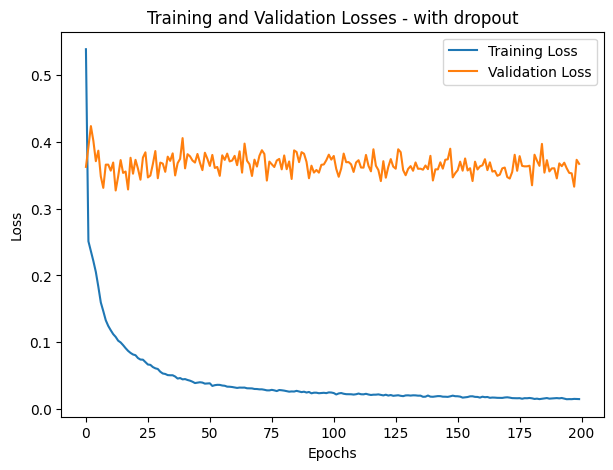

In [51]:
plt.figure(figsize=(7, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses - with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.xticks(range(0, len(train_losses), 1))  # Specify tick locations every 5 epochs
plt.legend()
plt.show()

In [28]:
model.eval()

test_loss = 0.0
test_image = []
ground_truth = []
predicted_patches = []

model.to(device)

with torch.no_grad():
    for batch in test_loader:
        # moving data to device
        images = batch['ct_generated'].float().to(device)
        std_maps = batch['std_map'].float().to(device)
        
        images = images.unsqueeze(0)
        std_maps = std_maps.unsqueeze(0)

        y_pred = model(images)

        # calculating loss
        loss = average_relative_error(y_pred, std_maps)
        #loss = criterion(y_pred, std_maps)
        test_loss += loss.item() * images.size(0)
        y_pred = y_pred.squeeze(0)

        # appending data for visualization
        test_image.append(images.cpu().numpy())
        ground_truth.append(std_maps.cpu().numpy())
        predicted_patches.append(y_pred.cpu().numpy())

# calculating average test loss
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.9991


In [31]:
# visualizing prediction

test_image_array = np.array(test_image)
ground_truth_array = np.array(ground_truth)
predicted_patches_array = np.array(predicted_patches)

test_image_array = test_image_array.reshape(8,8,64,64)
ground_truth_array = ground_truth_array.reshape(8,8,64,64)
predicted_patches_array = predicted_patches_array.reshape(8,8,64,64)

test_image_final = np.concatenate([np.concatenate(row, axis=1) for row in test_image_array], axis=0)
ground_truth_final = np.concatenate([np.concatenate(row, axis=1) for row in ground_truth_array], axis=0)
predicted_patches_final = np.concatenate([np.concatenate(row, axis=1) for row in predicted_patches_array], axis=0)
# Save the predicted_patches_final array to a file
#np.save('./results/seed104_nodr_predict.npy', predicted_patches_final)

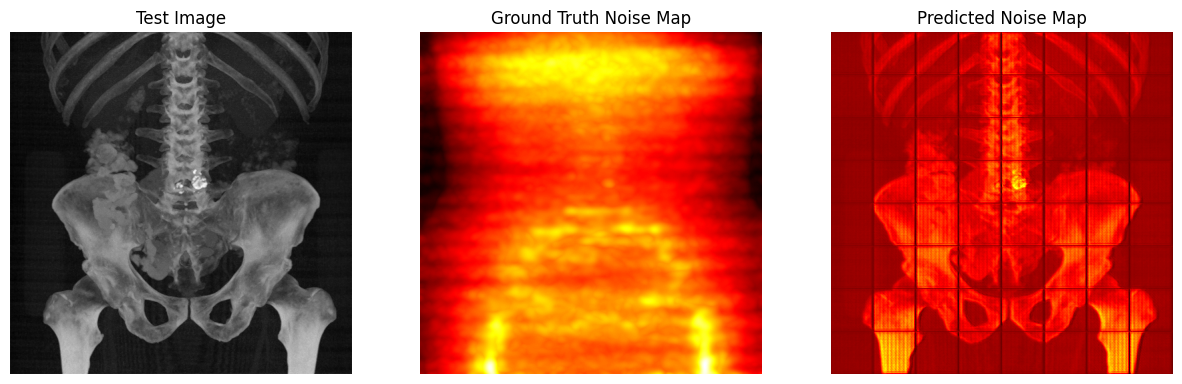

In [32]:
# Plot the test image
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth Noise Map')
plt.axis('off')


plt.subplot(133)
plt.imshow(np.rot90(predicted_patches_final), cmap='hot')
plt.title('Predicted Noise Map')
plt.axis('off')
plt.show()

In [35]:
# Load the predicted_patches_final array from a file
p4 = np.load('./results/seed4_predict.npy')
p54 = np.load('./results/seed54_predict.npy')
p104 = np.load('./results/seed104_predict.npy')
average_prediction = (p4 + p54 + p104) / 3
print(average_prediction)

[[3999.8645 4871.531  5033.97   ... 4936.045  4666.3335 3600.28  ]
 [4744.9673 4945.1304 4991.7095 ... 4878.156  4908.0605 4729.7017]
 [5013.9746 4983.16   5032.0586 ... 4882.194  4944.135  4993.936 ]
 ...
 [5431.666  5408.0225 5390.4336 ... 4940.971  4937.5947 4940.028 ]
 [5038.848  5337.5903 5403.4272 ... 4920.143  4899.9355 4693.8467]
 [3831.991  4937.8687 5405.101  ... 4908.145  4628.5874 3786.7356]]


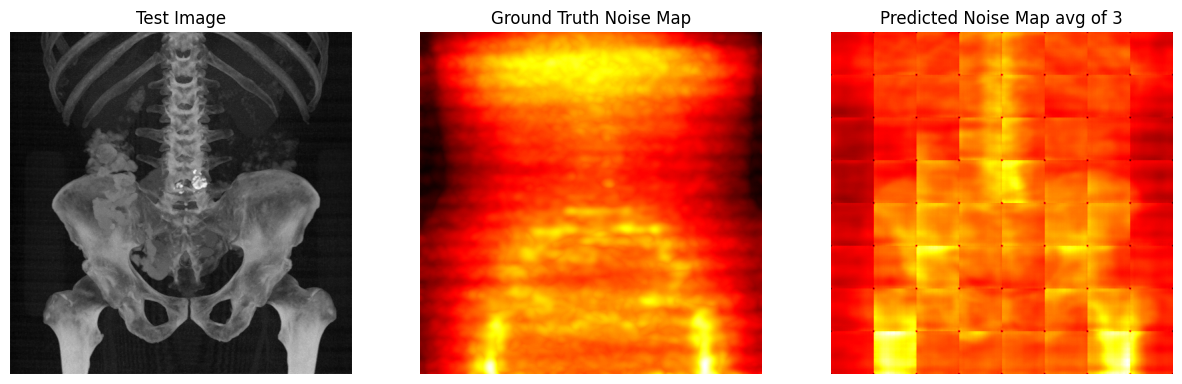

In [36]:
# Plot the test image
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(np.rot90(test_image_final), cmap='gray')
plt.title('Test Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.rot90(ground_truth_final), cmap='hot')
plt.title('Ground Truth Noise Map')
plt.axis('off')

plt.subplot(133)
plt.imshow(np.rot90(average_prediction), cmap='hot')
plt.title('Predicted Noise Map avg of 3')
plt.axis('off')
plt.show()

In [37]:
percent_error = (np.array(ground_truth_final) - np.array(average_prediction)) / np.array(ground_truth_final)
average_percent_error = abs(np.mean(np.abs(percent_error)))
print(average_percent_error)

0.13748218


Average Percentage Error: 13.75%


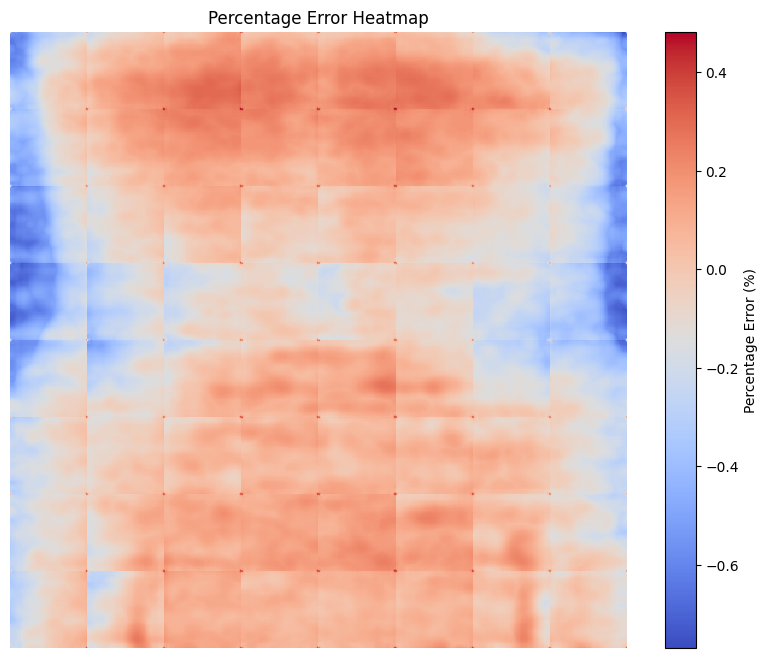

In [38]:
import numpy as np
import matplotlib.pyplot as plt

epsilon = 1e-8
ground_truth_final_safe = ground_truth_final + (ground_truth_final == 0) * epsilon

# Calculate the percentage error
percent_error = (ground_truth_final - average_prediction) / ground_truth_final_safe
average_percent_error = np.mean(np.abs(percent_error)) * 100  # Convert to percentage

print(f"Average Percentage Error: {average_percent_error:.2f}%")

# Plotting the percentage error as a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(np.rot90(percent_error), cmap='coolwarm', interpolation='none')
plt.colorbar(label='Percentage Error (%)')
plt.title('Percentage Error Heatmap')
plt.axis('off')  # Hide the axes
plt.show()


In [71]:
model.load_state_dict(torch.load('./results/RatUNet_seed4_wdr.pth'))

<All keys matched successfully>

In [73]:
print(model)

RatUNet(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.0, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): Dropout(p=0.0, inplace=False)
    )
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchN